# chainerの練習

$y=e^x$ という関数をいわゆるディープラーニングで学習してみましょう。

まず必要なモジュール類をインポートします。

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from matplotlib import pyplot as plt
%matplotlib inline

## 教師データの作成

まず教師データを出力する関数を作ります。バッチ学習という手法を使うので、
$n$ 個の問題・解答のセットを返す関数があると便利です。今回は0から1.0までの浮動小数$x$に対して$e^x$が期待値です。

In [2]:
def get_batch(n):
    x=np.random.random(n)
    y= np.exp(x)
    return x,y

In [3]:
print get_batch(2)

(array([ 0.46875115,  0.5620219 ]), array([ 1.59799728,  1.75421576]))


## ニューラルネットの設計

次に、ネットを作ります。

$y=e^x$ は非線形関数なので、線形関数だけでの近似では十分な精度が得られません。
入力を$x$としたとき、$y=Wx+b$のようなものを線形関数と呼びます。$W$を重み、$b$をバイアスと呼びますが、どちらもただの行列です。$x$に対する一次式で、つまり直線ですね。

さて、この線形演算に対して、
非線形関数による活性化層が入るだけでもうニューラルネットと呼んでいいらしいです。
それを多層にしたものがディープニューラルネット、いわゆるディープラーニングで使われる非線形関数です。どれぐらい深ければディープと呼んでいいのか不明ですが、今回は3段ぐらいにしてみます。

一般的な分類問題だとreluという非線形関数が非常によく使われますが、
reluだと微分消失してしまうので今回はleaky_reluを使います（この問題の場合はreluだと収束しませんでした）。

というわけで、構成は下記のようにしてみます。L1,L2,L3はそれぞれ線形関数で、その後にleaky_reluという関数が入っています。入力が負なら0.2をかける、というだけの関数です。いったん中間層の次元を16、32と増やしたあとに、最後に1次元に落としています。

<img src="chainer_00.png">

この中間層の次元をたくさん持てるということがネットワークの表現力を表しているわけです。
途中に非線形要素がなければ、

$$
\begin{eqnarray*}
 h_3 &=& W_3 (W_2(W_1x+b_1)+b_2)+b_3 \\
     &=& W_3 ( W_2W_1 x + W_2b_1 + b_2) +b_3 \\
     &=& W_3 W_2 W_1 x + W_3W_2b_1 + W_3b_2 + b_3 \\
     &=& W x + b
\end{eqnarray*}
$$

となり、$W_2$などがどんなに大きい次数をもった行列だったとしても実質は
$x,W,b$はすべて1次元です。つまり傾きと切片だけを変えられる直線で、すべての入出力にフィットしろ、と
いうことになってまあ無理がありますね。

最初の方で述べた「非線形要素があればニューラルネットと呼んでいい」というのはこういう理由なわけです。
中間層の次数を自由度として持てるのは非線形要素があってこそということになります。

## ニューラルネットの実装

これをchainerで書き下します。

chainerでは、最適化されるべきパラメータを持つ関数をL(リンク)、パラメータなしの関数をF(ファンクション)と呼んで区別しています。このあたりはver1.5あたりから導入された概念だそうで、リンクをファンクションで書いたりしているチュートリアルをよく見かけます。リンクはL.Linear(入力サイズ,出力サイズ)のように大文字始まりで、
ファンクションはF.linear(x,W,b)のように小文字始まりで定義されています。古いバージョンでは大文字始まりのファンクションが使われていたようで、F.Linear()とL.Linear()とF.linear()があります。前者２つは等価でパラメータを持った関数、最後のがパラメータを与えるただの関数、です。このあたり理解するまでにだいぶ混乱しました。

話がそれました。リンクをまとめたものを渡してチェインと呼ばれるクラスを作ります。
Pythonのクラスの書き方に慣れていないと面食らいますが、リンク一覧を定義する\_\_init\_\_()と
出力までの計算グラフを返す関数だけがあれば良いです。ここではロスを\_\_cal\_\_()で返す
ことにします。\_\_call\_\_()で定義した関数は 
```
m=MyChain()
loss=m(x,t)
```
のように呼べます。

パラメータを含む関数は\_\_init\_\_()に、それ以外は\_\_call()\_\_や他のメソッドで使うように
切り分けられているのがポイントですね。L.Linear()は入力チャネル、出力チャネル、の数だけをパラメータで渡せばいいのでTensorflowよりはるかに記述は簡単です。

In [4]:
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__(
             l1=L.Linear(1, 16),
             l2=L.Linear(16, 32),
             l3=L.Linear(32, 1),
        )

    def __call__(self,x,t):
        # xを入力した際のネットワーク出力と、回答t との差分を返します。
        # 今回は自乗誤差を使います。
        return F.mean_squared_error(self.predict(x),t)

    def  predict(self,x):
        # xを入力した際のネットワーク出力を返します。
        h1 = F.leaky_relu(self.l1(x))
        h2 = F.leaky_relu(self.l2(h1))
        h3 = F.leaky_relu(self.l3(h2))
        return h3

    def get(self,x):
        # xを実数で入力したら出力を実数で返すという便利関数です。
        # numpy.ndarrayとValiableを経由するので少々わかりにくいです。
        return self.predict(Variable(np.array([x]).astype(np.float32).reshape(1,1))).data[0][0]

特定の戦略にしたがってパラメータを最適化してくれるオプティマイザの設定をします。
今回はAdam()というものを使います。

In [5]:
model = MyChain()
optimizer = optimizers.Adam()
optimizer.setup(model)

## 学習

いよいよ学習ループを回します。

chainerの作法として、(バッチ軸, データ軸1,(データ軸2),..)という次元構造を持つ np.float32 の配列（テンソル）をVariableクラスに変換したものでやりとりします。Variableクラスから数値の実体を取り出すには dataメソッドを使います。

この場合は入力データが1次元なので、
  (バッチ軸、データ軸）
で良いですが、2次元画像のRGB３チャネルで構成されるデータは
  (バッチ軸、色軸、縦軸、横軸）
のように渡します。この辺も慣れないとわかりにくいですね。

学習のアップデートは
 
 1. 微分の初期化(zerograds)
 2. フォワードプロパゲーション（この場合は \_\_call()\_\_) 
 3. バックワードプロパゲーション（ネットを逆向きに辿ってパラメータの微分を計算する。backward）
 4. オプティマイザのアップデート
 
が一連の流れです。optimizer.update(model) でこの流れを一気にやってくれますが、どうせforwardの途中経過を覗きたくなるので、私は下記のようにすべて書くことが多いです。

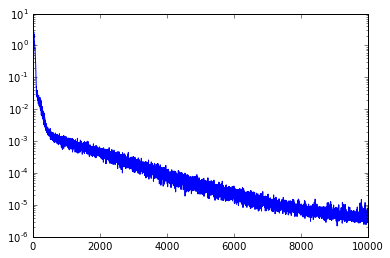

In [6]:
losses =[]
for i in range(10000):
    x,y = get_batch(100)
    x_ = Variable(x.astype(np.float32).reshape(100,1))
    t_ = Variable(y.astype(np.float32).reshape(100,1))
    
    model.zerograds()
    loss=model(x_,t_)
    loss.backward()
    optimizer.update()

    losses.append(loss.data)

plt.plot(losses)
plt.yscale('log')


横軸はループ回数、縦軸はlossをlogプロットしたものです。いい感じに減ってますね。

## 結果の確認

では、出来上がったモデルの出力を確認してみましょう。0.2を入れたらexp(0.2)に近い値が出るでしょうか。

In [7]:
print model.get(0.2)
print np.exp(0.2)

1.22095
1.22140275816


良さそうですね。では0から1の範囲でどれ位関数フィットできているでしょうか。

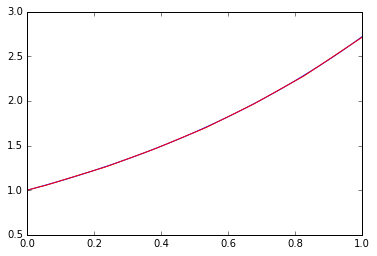

In [8]:
x=np.linspace(0,1,100)
plt.plot(x,np.exp(x))
plt.hold(True)
p=model.predict(Variable(x.astype(np.float32).reshape(100,1))).data
_=plt.plot(x, p,"r")

青が正解で、赤が学習結果です。

いい感じです。線形関数だけではこのフィット性能は出ませんよね。
ネットの深さ、幅（次元数）、などをいろいろ変えてみると面白いですが、よく言われているように、
幅よりも非線形要素と深さが重要、というのが確認できます。

## 学習結果モデルの観察

さて、結果学習後のモデルはどういう係数でできているのか見てみましょう。
たとえば最初のレイヤl1の重み$W$は下記のようにしてアクセスできます。

In [9]:
model.l1.W.data

array([[-0.07233309],
       [-0.3393594 ],
       [ 1.08829868],
       [-1.67671955],
       [ 0.27230689],
       [-0.61502671],
       [-0.95968199],
       [ 0.36463562],
       [-0.54369694],
       [ 1.52237678],
       [-1.77389479],
       [-1.28880453],
       [ 0.75955647],
       [-0.08282922],
       [-0.43932435],
       [ 1.17526913]], dtype=float32)

これを使って、たとえば下記のようなnumpyで同じ出力を返す関数を作れます。

In [10]:
def leaky_relu(x):
    # 要素ごとの演算にするために一度ndarrayを経由する
    m=np.array((x<0))
    x=np.array(x)
    return np.matrix((x*0.2)*m + x*(~m)) 

def pseudo_exp(x):
    x=np.matrix(x)
    W1=np.matrix(model.l1.W.data)
    b1 =np.matrix(model.l1.b.data)
    W2 =np.matrix(model.l2.W.data)
    b2  =np.matrix(model.l2.b.data)
    W3 =np.matrix(model.l3.W.data)
    b3  =np.matrix(model.l3.b.data)
    
    h1=leaky_relu(W1*x+b1.T)
    h2=leaky_relu(W2*h1+b2.T)
    h3=leaky_relu(W3*h2+b3.T)
    return h3

In [11]:
print pseudo_exp(0.2)
print np.exp(0.2)

[[ 1.22094863]]
1.22140275816


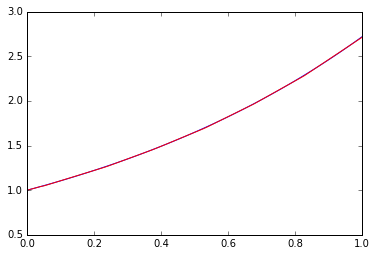

In [12]:
x=np.linspace(0,1,100)
plt.plot(x,np.exp(x))
plt.hold(True)
p=pseudo_exp(x.T)
_=plt.plot(x, p.T,"r")

model.l1.W.dataなどの係数値をそのまま書き下せば、完全にnumpyだけで学習結果モデルを書けます。
CやGoなどの言語へ変換するのも難しくはないでしょう。まあ、chainerやnumpyは利便性の割には十分速いので、速度だけの理由で他の言語に変換する必要はないと思いますが。

## 途中経過の観察とセーブ

さて、Jupyter上で試行錯誤する際に、途中経過を眺めたくなるでしょう。
下記のように書くと途中経過のプロットが更新されます。収束速度にもよりますが、
10回に1回表示を更新するようにしています。

さらに、セーブ重要です。100回に1回セーブします。

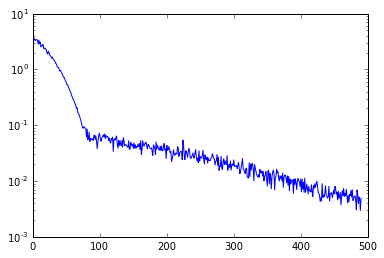

In [13]:
losses =[]
from IPython import display

model = MyChain()
optimizer = optimizers.Adam()
optimizer.setup(model)

plt.hold(False)

for i in range(500):
    x,y = get_batch(100)
    x_ = Variable(x.astype(np.float32).reshape(100,1))
    t_ = Variable(y.astype(np.float32).reshape(100,1))
    
    model.zerograds()
    loss=model(x_,t_)
    losses.append(loss.data)
    loss.backward()
    optimizer.update()

    if i%10==0:
        plt.plot(losses,"b")
        plt.yscale('log')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if i%100==0:
        serializers.save_npz('my.model', model)

display.clear_output(wait=True)


セーブしたモデルを使って出力を見てみます。

In [14]:
serializers.load_npz('my.model',model)
model.get(0.2)

1.1286017

## バックプロパゲーションとは

さて、もう少し原理的なところを理解したいところです。そもそもバックプロパゲーションでパラメータ最適化される、というのはどういうことでしょうか。

簡単のために一度ネットワークを線形関数（$y=Wx+b$で$W,b$がスカラーというただの一次式）に戻して、かつ、オプティマイザをシンプルなSGDに戻します。バッチも1つだけにします。

$W,b$ の初期値ですが、chainerのデフォルトは、$W$が乱数、$b$が$0$に選ばれます。ここではわかりやすさのために、$W=0, b=0$を初期値としましょう。

In [15]:
def get_batch(n):
    x=np.random.random(n)
    y= np.exp(x)
    return x,y

class LinearChain(Chain):
    def __init__(self):
        super(LinearChain, self).__init__(
             l1=L.Linear(1, 1,initialW=0.0),
        )

    def __call__(self,x,t):
        return F.mean_squared_error(self.predict(x),t)

    def  predict(self,x):
        return self.l1(x)

    def get(self,x):
        return self.predict(Variable(np.array([x]).astype(np.float32).reshape(1,1))).data[0][0]

$y=Wx+b$ という線形関数に対して、$E=(y-t)^2$ という自乗誤差を誤差関数として定義しました。

この自乗誤差を0に近づけるためにパラメータである$W$と$b$を更新していくわけですが、
更新の方向は誤差$E$をそれぞれのパラメータで偏微分したもので定義されます。つまり、

$$
\varDelta W = \frac{\partial E}{\partial W},\quad
\varDelta b =  \frac{\partial E}{\partial b} 
$$ 

です。この値をパラメータの微分と呼んでいます。この式を展開すると、

$$
\begin{eqnarray*}
\varDelta W &=& \frac{\partial E}{\partial y} \frac{\partial y}{\partial W} &=& 2 \left(y-t \right) x \\
\varDelta b &=& \frac{\partial E}{\partial y} \frac{\partial y}{\partial b} &=& 2 \left( y-t \right) \\
\end{eqnarray*}
$$ 

となります。こう変形することで、パラメータの微分が、誤差の差分である$y-t$ 、既知の入力$x$、で表せたわけです。演算の過程で、下流である誤差の差分から上流の式のパラメータの差分に戻ってくるわけなので、
バックプロパゲーションと呼びます。$t,x$ は既知ですが、$y$は、フォワードプロパゲーション、つまり $Wx+b$ を計算しないと得られません。ということで、フォワードプロパゲーションののちにバックプロパゲーション、
という演算をすればパラメータの差分が得られるわけですね。

こうやって計算された$\varDelta W, \varDelta b$ を使って
$W,b$ を更新します。
SGDは単純に傾きに一定の学習率$\alpha$をかけたぶんだけパラメータを更新します。つまり
$$
\begin{eqnarray*}
W&\leftarrow&W-\alpha \varDelta W \\
b&\leftarrow&b-\alpha\varDelta b \\
\end{eqnarray*}
$$ 
という風に更新されていきます。なお、chainerのデフォルトは$\alpha=0.01$です。

この動きを確認してみましょう。

In [19]:
model2 = LinearChain()
optimizer2 = optimizers.SGD()
optimizer2.setup(model2)

losses=[]
trace=[]

def scalar(v):
    # Valiableをスカラー値に戻す
    return v.data.ravel()[0]

for i in range(5):
    x,y = get_batch(1)
    x_ = Variable(x.astype(np.float32).reshape(1,1))
    t_ = Variable(y.astype(np.float32).reshape(1,1))
    
    model2.zerograds()
    loss=model2(x_,t_)        
    loss.backward(retain_grad=True)

    y = scalar(model2.predict(x_))
    t=scalar(t_)
    x=scalar(x_)
    W=scalar(model2.l1.W)
    b=scalar(model2.l1.b)
    dW=model2.l1.W.grad.ravel()[0]
    db=model2.l1.b.grad.ravel()[0]

    print "======  step %d  ======" % i
    print "W,b  \t\t\t\t%2.8f, %2.8f" % (W,b)
    print "2(y-t)x\t\t\t\t%2.8f, %2.8f" % (2*((y-t)*x), 2*((y-t)))
    print "⊿W,⊿b\t\t\t\t%2.8f, %2.8f" % (dW,db)   #chainerの出すdelta_W, delta_b
    print "W-α⊿W,b-α⊿b \t\t%2.8f, %2.8f" % (W-0.01*dW,b-0.01*db)
    optimizer2.update()


======  step 0  ======
W,b  				0.00000000, 0.00000000
2(y-t)x				-3.31116819, -4.31112576
⊿W,⊿b				-3.31116819, -4.31112576
W-α⊿W,b-α⊿b 		0.03311168, 0.04311126
======  step 1  ======
W,b  				0.03311168, 0.04311126
2(y-t)x				-2.21128297, -3.58129072
⊿W,⊿b				-2.21128297, -3.58129072
W-α⊿W,b-α⊿b 		0.05522451, 0.07892416
======  step 2  ======
W,b  				0.05522451, 0.07892416
2(y-t)x				-0.38491392, -2.20442820
⊿W,⊿b				-0.38491392, -2.20442820
W-α⊿W,b-α⊿b 		0.05907365, 0.10096845
======  step 3  ======
W,b  				0.05907365, 0.10096844
2(y-t)x				-0.27022040, -2.06254911
⊿W,⊿b				-0.27022040, -2.06254911
W-α⊿W,b-α⊿b 		0.06177585, 0.12159393
======  step 4  ======
W,b  				0.06177585, 0.12159394
2(y-t)x				-2.15544128, -3.42905116
⊿W,⊿b				-2.15544128, -3.42905116
W-α⊿W,b-α⊿b 		0.08333026, 0.15588445


以下２点が確認できます。
- $2(y-t)x$と同じ値をchainerのgradが返している
- 0.01gradぶんずつ$W,b$ が更新されている

さて、更新の結果、最適値に近づいていく様子を見てみましょう。

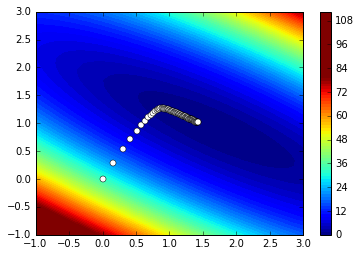

In [20]:
import matplotlib.path as mpath
import matplotlib.patches as patches

# ロスの等高線を書く
psize=40

W=np.linspace(-1,3,psize)
B=np.linspace(-1,3,psize)
Wm, Bm = np.meshgrid(W, B)

Z=np.zeros((psize,psize))
for w in range(psize):
    for b in range(psize):
        Z[b,w]=0.0
        for x in np.linspace(0,1,10):
            Z[b,w] += (W[w]*x+B[b]-np.exp(x))**2

plt.contourf(Wm,Bm, Z, 100,vmax=80,vmin=0)
plt.colorbar()
plt.hold(True)
    
model2 = LinearChain()
optimizer2 = optimizers.SGD()
optimizer2.setup(model2)

losses=[]
verts = [ ]
batchsize=20

for i in range(1000):

    x,y = get_batch(batchsize)
    x_ = Variable(x.astype(np.float32).reshape(batchsize,1))
    t_ = Variable(y.astype(np.float32).reshape(batchsize,1))

    if i%10==0:
        w= model2.l1.W.data[0][0]
        b = model2.l1.b.data[0]
        verts.append((w,b))
    
    model2.zerograds()
    loss=model2(x_,t_)
    loss.backward()
    optimizer2.update(retain_grad=True)

xs, ys = zip(*verts)
_=plt.plot(xs, ys, 'o', lw=1, color='white') #, ms=10)

横軸が$W$, 縦軸が $b$ です。等高線はロスを示しています。底に向かって進んでいるのがわかります。

もちろん、単純化したので最適点でも直線です。最小二乗近直線ですね。似下に示します。

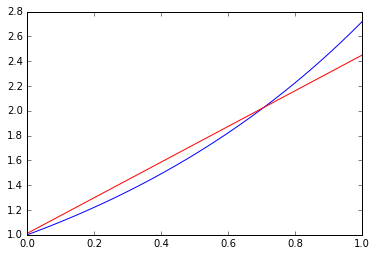

In [18]:
x=np.linspace(0,1,100)
plt.plot(x,np.exp(x))
plt.hold(True)
p=model2.predict(Variable(x.astype(np.float32).reshape(100,1))).data
_=plt.plot(x, p,"r")